# Filter Visualization
Visualizing filters learned by a CNN

In [9]:
# Viz imports
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import sys
import os

# Numpy
import numpy as np
from skimage import color, io

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Torchvision
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Dataset
from torchvision.datasets import CIFAR10

## Training params

In [2]:
num_epochs = 150
batch_size = 256
learning_rate = 1e-3
use_gpu = True
nfilters = 25

## Dataset

In [3]:
# Data augmentation
# Random crops & flips
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=transform_train, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=transform_test, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## CNN

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=9, stride=1, padding=4) # out: 48 x 32 x 32
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # out: 48 x 16 x 16
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=9, stride=1, padding=4) # out: 96 x 16 x 16
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # out: 96 x 8 x 8
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # out: 96 x 8 x 8
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # out: 96 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=0) # out: 96 x 1 x 1
        self.do1 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(64, 10) # 10 outputs

    def forward(self, x):
        # convolutional 
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.do1(x)
        x = x.view(x.size(0), -1) # flatten
        
        # fully connected 
        x = F.log_softmax(self.fc1(x), dim=1) # classifier activation
        
        return x

convnet = ConvNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
convnet = convnet.to(device)
    
# Filters to plot
filter_inds = []
for conv in [convnet.conv1, convnet.conv2, convnet.conv3, convnet.conv4]:
    weights = conv.weight.data.view(-1, 1, conv.weight.size(2), conv.weight.size(3))
    filter_inds.append(np.random.choice(weights.size(0), min(nfilters, weights.size(0)), replace=False))

num_params = sum(p.numel() for p in convnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 250666


In [5]:
optimizer = torch.optim.Adam(params=convnet.parameters(), lr=learning_rate)

# Training mode: ON
convnet.train()

train_loss_avg = []

filters = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    filters.append([])
    
    for image_batch, label_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        
        # class predictions
        prediction_batch = convnet(image_batch)
        
        # Negative log likelihood loss
        loss = F.nll_loss(prediction_batch, label_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    # Filter evolution
    for i, conv in enumerate([convnet.conv1, convnet.conv2, convnet.conv3, convnet.conv4]):
        weights = conv.weight.data.view(-1, 1, conv.weight.size(2), conv.weight.size(3))
        filters[-1].append(weights[filter_inds[i], :, :, :].cpu())
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 150] average loss: 1.772794
Epoch [2 / 150] average loss: 1.483501
Epoch [3 / 150] average loss: 1.344800
Epoch [4 / 150] average loss: 1.240613
Epoch [5 / 150] average loss: 1.155851
Epoch [6 / 150] average loss: 1.081138
Epoch [7 / 150] average loss: 1.016117
Epoch [8 / 150] average loss: 0.966858
Epoch [9 / 150] average loss: 0.925662
Epoch [10 / 150] average loss: 0.886239
Epoch [11 / 150] average loss: 0.859739
Epoch [12 / 150] average loss: 0.828863
Epoch [13 / 150] average loss: 0.800073
Epoch [14 / 150] average loss: 0.779497
Epoch [15 / 150] average loss: 0.760678
Epoch [16 / 150] average loss: 0.738703
Epoch [17 / 150] average loss: 0.728243
Epoch [18 / 150] average loss: 0.702465
Epoch [19 / 150] average loss: 0.691534
Epoch [20 / 150] average loss: 0.678586
Epoch [21 / 150] average loss: 0.670323
Epoch [22 / 150] average loss: 0.661933
Epoch [23 / 150] average loss: 0.642892
Epoch [24 / 150] average loss: 0.633723
Epoch [25 / 150] average loss: 0.627

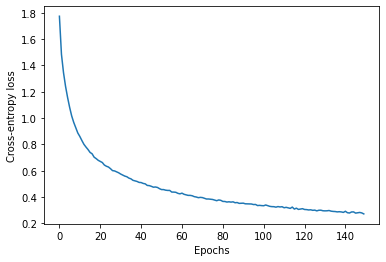

In [6]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

## Evaluation

In [7]:
# Evaluation mode: ON
convnet.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0
for image_batch, label_batch in test_dataloader:
    
    with torch.no_grad():
        
        # Get data
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # Predict
        prediction_batch = convnet(image_batch)

        # Count correct predictions
        _, predicted_label = prediction_batch.max(dim=1)
        num_incorrect += (predicted_label != label_batch).sum().item()

        # Negative log likelihood loss
        loss = F.nll_loss(prediction_batch, label_batch)

        test_loss_avg += loss.item()
        num_batches += 1
        num_instances += image_batch.size(0)
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))

average loss: 0.570586
classification error: 15.770000%


## Feature Visualization

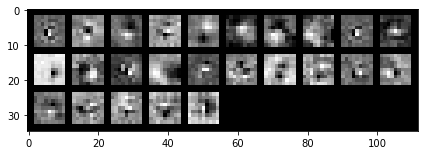

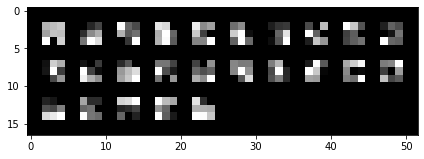

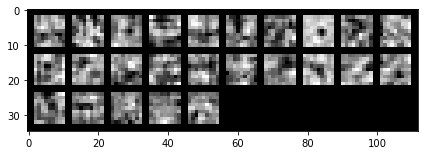

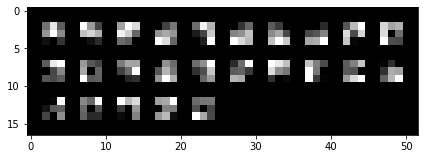

In [12]:
with torch.no_grad():

    def filter_collage(filter_weights, nrow):
        filter_max = filter_weights.view(filter_weights.size(0), 1, -1).max(dim=2)[0].view(filter_weights.size(0), 1, 1, 1)
        filter_min = filter_weights.view(filter_weights.size(0), 1, -1).min(dim=2)[0].view(filter_weights.size(0), 1, 1, 1)
        filter_weights = (filter_weights - filter_min) / (filter_max - filter_min)
        return torchvision.utils.make_grid(filter_weights, nrow=nrow)

    def show_tensor(tensor):
        fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
        ax.imshow(np.transpose(tensor.numpy(), (1, 2, 0)))
        plt.show()

    show_tensor(filter_collage(filters[-1][0], nrow=10))
    show_tensor(filter_collage(filters[-1][1], nrow=10))
    show_tensor(filter_collage(filters[-1][2], nrow=10))
    show_tensor(filter_collage(filters[-1][3], nrow=10))